In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import zipfile
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
from torchvision import transforms
import torch.nn as nn
from typing import Dict, List
from torch.optim.lr_scheduler import StepLR
from timeit import default_timer as timer 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [4]:
train_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip"
test_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip"

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall("data/")
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall("data/")

In [5]:
from sklearn.model_selection import train_test_split

train_paths = os.listdir('data/train/')
train_paths = ['data/train/' + i for i in train_paths]

# Split train and validation data
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, shuffle=True, random_state=42)

In [6]:
print(f'Train images: {len(train_paths)}')
print(f'Validation images: {len(val_paths)}')

Train images: 20000
Validation images: 5000


In [7]:
mytransform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

In [8]:
class MyDataLoader(Dataset):
    def __init__(self, data_path, transform = None):
        self.data = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        if 'dog' in self.data[idx]:
            label = 1
        elif 'cat' in self.data[idx]:
            label = 0
            
        return image, label

In [9]:
# Train dataset
train_dataset = MyDataLoader(data_path=train_paths, transform=mytransform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataset
val_dataset = MyDataLoader(data_path=val_paths,  transform=mytransform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
# Get a batch of testing data
images, labels = next(iter(train_dataloader))
images.shape, labels.shape

(torch.Size([32, 3, 200, 200]), torch.Size([32]))

In [11]:
# Get a batch of testing data
images, labels = next(iter(val_dataloader))
images.shape, labels.shape

(torch.Size([32, 3, 200, 200]), torch.Size([32]))

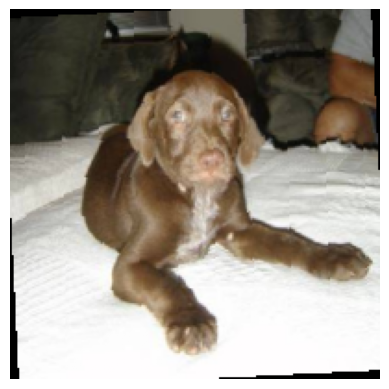

In [12]:
# Display a photo from the dataset
image = train_dataset.__getitem__(42)[0]
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy());

In [13]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=2, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, padding=0, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units*2, hidden_units*2*2, kernel_size=3, padding=0, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ) 
        
        self.classifier = nn.Sequential(
            nn.Linear(64*2*2,10),
            nn.ReLU(),
            #self.dropout = nn.Dropout(0.5),
            nn.Linear(10,output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.conv_block_3(x)
        #print(x.shape)
        # Flatten the output from conv layers before passing it to classifier
        x = x.view(x.size(0), -1) 
        #print(x.shape) # print to see the shape after flattening
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [14]:
from torchinfo import summary
# Ensure that your model is transferred to the appropriate device (CPU or CUDA)
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=16, 
                  output_shape=2 # Number of Class labels, for ex: Cat & Dog 
                 )
model_0.to(DEVICE)

# Displaying the summary with input size matching your model's input
summary(model_0, input_size=(32, 3, 200, 200))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 2]                   --
├─Sequential: 1-1                        [32, 16, 49, 49]          --
│    └─Conv2d: 2-1                       [32, 16, 99, 99]          448
│    └─BatchNorm2d: 2-2                  [32, 16, 99, 99]          32
│    └─ReLU: 2-3                         [32, 16, 99, 99]          --
│    └─MaxPool2d: 2-4                    [32, 16, 49, 49]          --
├─Sequential: 1-2                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-5                       [32, 32, 24, 24]          4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 24, 24]          64
│    └─ReLU: 2-7                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-8                    [32, 32, 12, 12]          --
├─Sequential: 1-3                        [32, 64, 2, 2]            --
│    └─Conv2d: 2-9                       [32, 64, 5, 5]            18,496
│    └─

In [15]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(DEVICE))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 200, 200])

Output logits:
tensor([[-0.2816, -0.2503]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4922, 0.5078]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


In [16]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(DEVICE), y.to(DEVICE)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(DEVICE), y.to(DEVICE)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [19]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=16, 
                  output_shape=2).to(DEVICE)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5784 | train_acc: 0.6938 | test_loss: 0.6566 | test_acc: 0.6636
Epoch: 2 | train_loss: 0.4954 | train_acc: 0.7595 | test_loss: 0.4697 | test_acc: 0.7757
Epoch: 3 | train_loss: 0.4510 | train_acc: 0.7847 | test_loss: 0.4660 | test_acc: 0.7789
Epoch: 4 | train_loss: 0.4267 | train_acc: 0.8005 | test_loss: 0.4234 | test_acc: 0.8089
Epoch: 5 | train_loss: 0.4072 | train_acc: 0.8142 | test_loss: 0.4114 | test_acc: 0.8081
Epoch: 6 | train_loss: 0.3920 | train_acc: 0.8206 | test_loss: 0.3858 | test_acc: 0.8205
Epoch: 7 | train_loss: 0.3746 | train_acc: 0.8324 | test_loss: 0.4145 | test_acc: 0.8067
Epoch: 8 | train_loss: 0.3643 | train_acc: 0.8345 | test_loss: 0.3989 | test_acc: 0.8127
Epoch: 9 | train_loss: 0.3580 | train_acc: 0.8408 | test_loss: 0.4076 | test_acc: 0.8163
Epoch: 10 | train_loss: 0.3440 | train_acc: 0.8470 | test_loss: 0.3825 | test_acc: 0.8252
Total training time: 813.373 seconds


## **Transfer Learning**

In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
transfer_model_1 = torchvision.models.efficientnet_b0(weights=weights).to(DEVICE)
#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 9.81MB/s]


In [21]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [22]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=transfer_model_1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [23]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in transfer_model_1.features.parameters():
    param.requires_grad = False

In [24]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = 2

# Recreate the classifier layer and seed it to the target device
transfer_model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(DEVICE)

In [25]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(transfer_model_1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [26]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=transfer_model_1.parameters(), lr=0.001)
start_time = timer()

transfer_model_1_results = train(model=transfer_model_1, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2145 | train_acc: 0.9132 | test_loss: 0.1290 | test_acc: 0.9536
Epoch: 2 | train_loss: 0.1699 | train_acc: 0.9277 | test_loss: 0.1178 | test_acc: 0.9564
Epoch: 3 | train_loss: 0.1618 | train_acc: 0.9311 | test_loss: 0.1205 | test_acc: 0.9530
Epoch: 4 | train_loss: 0.1552 | train_acc: 0.9362 | test_loss: 0.1228 | test_acc: 0.9516
Epoch: 5 | train_loss: 0.1603 | train_acc: 0.9332 | test_loss: 0.1217 | test_acc: 0.9512
Total training time: 491.156 seconds


Prediction: Cat


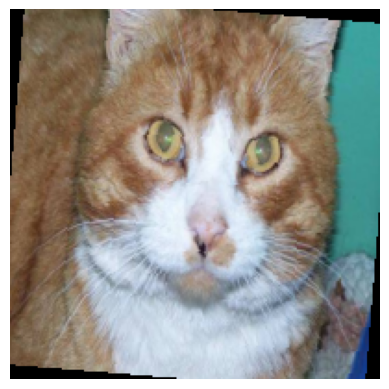

In [27]:
img = train_dataset.__getitem__(22)[0]

transfer_model_1.eval()
with torch.no_grad():
    out = transfer_model_1(img.unsqueeze(0).to(DEVICE))

print(f'Prediction: {"Cat" if out.argmax().item() == 0 else "Dog"}')

plt.axis('off')
plt.imshow(img.permute(1, 2, 0).cpu().numpy());

In [28]:
predictions = np.array([]).astype('int')

for i in range(12500):
    img_path = os.path.join('/kaggle/working/data/test', str(i+1)+'.jpg')
    image = Image.open(img_path).convert("RGB")
    image = auto_transforms(image)

    transfer_model_1.eval()
    with torch.no_grad():
        out = transfer_model_1(image.unsqueeze(0).to(DEVICE)).flatten()

    predictions = np.append(predictions, out.argmax().item())

In [29]:
submission = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission['label'] = predictions
submission.head()

submission.to_csv('submission_1.csv')